# Outline of Notebook

The notebook follows the general outline of machine learning projects:

1. Look at the Big Picture:
	- Frame the problem
	- Describe the data sources
	- Define performance metric: ROC_AUC
2. Get the Data
	- Import packages
	- Read the data
	- Take a Quick Look at the Data Structure
3. Prepare the Data
    - Handling categorical attributes
    - Handling missing values
    - Handling datetime
4. Exploratory Data Analysis 
	- Univariate Analysis 
	- Bivariate Analysis
		- Correlation and coefficient
		- Plotting
5. Feature Engineering
6. Train model
	- 6.1 RandomForestClassifier
		- Train model
		- Tune the model with GridSearchCV
		- Investigate feature importances
	- 6.2 ExtraTreesClassifier
    - 6.3 LightGBM

# 1. Look at the Big Picture

## Frame the Problem: Affiliate network fraud detection case study

This notebook intends to conduct an Exploratory Data Analysis (EDA) and perform a prediction modelling of publishers' fraud after registration.

## Description data

Sources of data includes: test_dataset.csv

Columns:

- User’s credentials (username and password ). Note: password is not hashed!
- Publisher: Whoever makes our advertising available on his website and display it to
visitors in order to receive a commission per registration.
- Partner: Affiliate Network acting as middle man for advertisers (us or our competitors)
to its publishers ­ webmasters, bloggers and any contributor that provides traffic
(visits to websites). Therefore, a publisher usually belongs to a certain partner.
- Domain: The product where the user made his registration
- Registration date and time
- is_fake: Decision whether the registered user is fraud or not based on certain
transaction which is considered to be human and not artificial (something similar to reCAPTCHA).

## Metric: ROC AUC

The metric in this case is a common classification metric known as the [Receiver Operating Characteristic Area Under the Curve (ROC AUC)](https://stats.stackexchange.com/questions/132777/what-does-auc-stand-for-and-what-is-it).

The ROC curve graphs the true positive rate versus the false positive rate.

The [Area Under the Curve (AUC)](http://gim.unmc.edu/dxtests/roc3.htm) is the area under the ROC curve. This metric is between 0 and 1 with a better model scoring higher. A model that simply guesses at random will have a ROC AUC of 0.5.


# 2. Get the Data 

## Import packages

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import pandas as pd
import numpy as np
np.random.seed=42
import os as os
import datetime
import warnings
warnings.filterwarnings("ignore")

# Import specific packages
from scipy.sparse import csr_matrix

from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.metrics import roc_auc_score

from sklearn.utils import shuffle

from sklearn.preprocessing import Imputer

import lightgbm as gbm

# To plot pretty figures
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import seaborn as sns

## Read the Data

In [2]:
# List files available
data_path = './data'
files = os.listdir(data_path)
print(files)

['test_dataset.csv']


In [3]:
# Read data
train = pd.read_csv(os.path.join(data_path, 'test_dataset.csv'))

## Take a Quick Look at the Data Structure

In [4]:
print('Training data shape: ', train.shape)
train.head()

Training data shape:  (1000000, 7)


,username,password,publisher,register_datetime,domain,partner,is_fake
0,glenister,38cli9z,pub_97409,2017-01-01 22:01:35,d_42_com,par_17,0
1,kim12349,password,pub_22326,2017-01-01 22:07:26,d_42_com,par_58,0
2,bxalcbmah,l84o1aa,pub_85995,2017-01-01 22:09:22,d_63_com,par_29,0
3,chokeme,895263,pub_16333,2017-01-01 22:10:28,d_42_com,par_17,0
4,umbriel,requete,pub_81878,2017-01-01 22:14:58,d_31_com,par_29,0


# 3. Prepare data

### Handling categorical attributes

This notebook will use the Owen Zhang's *[leave-one-out-encoding](https://www.kaggle.com/c/caterpillar-tube-pricing/discussion/15748)* to encode categorical features:
- username
- password
- publisher
- domain
- partner

### Handling missing values

The notebook applies different strategic in handling categorical variables and numerical variables:
- For the missing categorical values, we will fill them with 'NaN' and treat them as a group.
- For the missing numerical values, we will use an imputer to imputer it with the median value.
	- As some of the value of categorical features might have only one row, which might result in NaN in the leave-one-out-encoding. For such cases, we will impute the missing values with median.

### Handling datetime

To have a more detailed look at the time patterns, the notebook will transform the *register_datetime* to: hour, weekday, day, month, year, calener_week

In [5]:
def transform_datetime(df, col):
    df[col] = df[col].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    df['year'] = df[col].apply(lambda x: x.year)
    df['month'] = df[col].apply(lambda x: x.month)
    df['day'] = df[col].apply(lambda x: x.day)
    df['weekday'] = df[col].apply(lambda x: x.weekday())
    df['hour'] = df[col].apply(lambda x: x.hour)
    # %W - week number of the current year, starting with the first Monday as the first day of the first week.
    df['cw'] = df[col].apply(lambda x: int(x.strftime('%W')))

In [6]:
# leave one out encoding
def cal_leave_one_out(df, col, target):
    # mean of group
    mean = df.groupby([col])[target].transform('mean')
    # number of group
    n = df.groupby([col])[target].transform('count')
    # average of group without current line
    col_mean = '{0}_mean'.format(col)
    df[col_mean] = (mean * n - df[target]) / (n-1)
    # add some noise
    df['noise'] = np.random.normal(1, 0.2, [df.shape[0], 1])
    col_name = '{0}_leave_one_out'.format(col)
    df[col_name] = df[col_mean] * df['noise']
    df.drop([col_name, 'noise'], axis=1)

In [7]:
def impute_and_clip(df, num_var, imputer, clip):
    df = df[num_var]
    data = imputer.transform(df)
    df = pd.DataFrame(data, columns=num_var)
    # limit the leave_one_out value to certain range between (0,2)
    if clip:
        df[leave_one_out_var] = df[leave_one_out_var].clip(0, 2)
    return df

In [8]:
cat_var = ['username', 'password', 'publisher', 'domain', 'partner']

num_var = ['year', 'month', 'day', 'weekday', 'hour', 'cw', \
           'username_leave_one_out', 'password_leave_one_out', 'publisher_leave_one_out', 'partner_leave_one_out', 'domain_leave_one_out']

leave_one_out_var = ['username_leave_one_out', 'password_leave_one_out', 'publisher_leave_one_out', 'partner_leave_one_out', 'domain_leave_one_out']

# Transform datetime
transform_datetime(train, 'register_datetime')
train = train.drop('register_datetime', axis=1)

# Fill missing categorical value with string 'NaN'
train[cat_var] = train[cat_var].fillna('NaN')

# Hold out last month's data for testing
tr = train[train['month'] < 12]
te = train[train['month'] == 12]

# Calculate leave one out encoding
for cat in cat_var:
    cal_leave_one_out(tr, cat, 'is_fake')

# Train imputer    
imputer = Imputer(strategy='median')
tr_num = tr[num_var]
imputer.fit(tr_num)

# Impute numerical variable
tr_num = impute_and_clip(tr, num_var, imputer, True)


Now that we have encoded the categorical features, let's apply this to the validation set and testing set.

In [9]:
# Join categorical values and leave-one-out score 
tmp_encoded = pd.concat([tr[cat_var], tr_num[leave_one_out_var]], axis=1)

# Calculate mean of each categorical value
tmp_username = tmp_encoded.groupby('username', as_index=False)['username_leave_one_out'].mean()
tmp_password = tmp_encoded.groupby('password', as_index=False)['password_leave_one_out'].mean()
tmp_publisher = tmp_encoded.groupby('publisher', as_index=False)['publisher_leave_one_out'].mean()
tmp_partner = tmp_encoded.groupby('partner', as_index=False)['partner_leave_one_out'].mean()
tmp_domain = tmp_encoded.groupby('domain', as_index=False)['domain_leave_one_out'].mean()

# Merge testing set with the tmp tables above
te = te.merge(tmp_publisher, how='left', on='publisher')\
    .merge(tmp_partner, how='left', on='partner')\
    .merge(tmp_domain, how='left', on='domain')\
    .merge(tmp_username, how='left', on='username')\
    .merge(tmp_password, how='left', on='password')

del tmp_publisher, tmp_partner, tmp_domain, tmp_encoded, tmp_username, tmp_password

# impute missing value for testing set
te_num = impute_and_clip(te, num_var, imputer, True)



# 4. Exploratory data analysis

Exploratory data analysis (EDA) is an open-ended process. It usually starts out with a univariate analysis, which gives an overview of distribution of attributes and helps us to identify trends in the data. After a univariate analysis, we can take a closer look at the relationships between attributes, which we also call it bivariate analysis.

In this EDA of this notebook, we will go through:

- Univariate Analysis 
- Bivariate Analysis

## Univariate Analysis

In [10]:
# Take a look at general statistic
print(train.describe(include='all'))

       username password  publisher    domain  partner         is_fake  \
count   1000000  1000000    1000000   1000000  1000000  1000000.000000   
unique   918560   681134       9244        27       98             NaN   
top        info   123456  pub_85995  d_63_com   par_29             NaN   
freq        266     5566      86623    421581   245526             NaN   
mean        NaN      NaN        NaN       NaN      NaN        0.076012   
std         NaN      NaN        NaN       NaN      NaN        0.265017   
min         NaN      NaN        NaN       NaN      NaN        0.000000   
25%         NaN      NaN        NaN       NaN      NaN        0.000000   
50%         NaN      NaN        NaN       NaN      NaN        0.000000   
75%         NaN      NaN        NaN       NaN      NaN        0.000000   
max         NaN      NaN        NaN       NaN      NaN        1.000000   

             year           month             day         weekday  \
count   1000000.0  1000000.000000  1000000

In [11]:
# Helper Functions


# display the count of the x_feature
def count_plot(x_feature, title):
    data = train
    sns.countplot(x=x_feature, data=data)
    plt.title(title)
    
    
# display density of x_feature
def plot_density(x_feature, max_val, title):
    data = tr
    if max_val:
        sns.kdeplot(data[x_feature][(data['is_fake'] == 0) & (data[x_feature] <= max_val)], label='Is fake (0)')
        sns.kdeplot(data[x_feature][(data['is_fake'] == 1) & (data[x_feature] <= max_val)], label='Is fake (1)') 
    else: 
        sns.kdeplot(data[x_feature][data['is_fake'] == 0], label='Is fake (0)')
        sns.kdeplot(data[x_feature][data['is_fake'] == 1], label='Is fake (1)')
    plt.xlabel(x_feature)
    plt.ylabel('Density')
    plt.title(title)

Let's first examine the distribution of attributes.


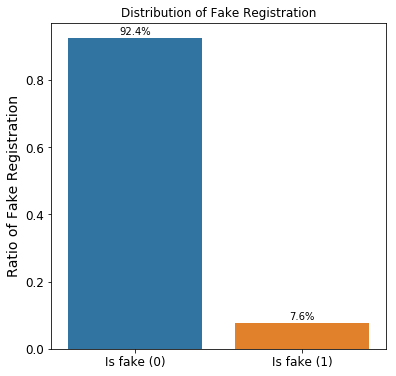

In [12]:
is_fake_mean = train['is_fake'].mean()
x = ['Is fake (0)', 'Is fake (1)']
y = [1-is_fake_mean, is_fake_mean]
plt.figure(figsize=(6,6))
g = sns.barplot(x, y)
for p, uniq in zip(g.patches, y):
    height = p.get_height()
    g.text(p.get_x() + p.get_width()/2, height+0.01, '{0}%'.format(round(uniq*100, 2)), ha='center')
plt.ylabel('Ratio of Fake Registration')
plt.title('Distribution of Fake Registration')
plt.savefig('./images/Distribution_of_Fake_Registration')

There is about 7.6% of the fake registration.

In [13]:
username = train['username'].value_counts().reset_index(name='counts')[:10]
username.columns = ['username', 'count']
username

,username,count
0,info,266
1,admin,228
2,richard,118
3,michael,116
4,david,110
5,NaN,105
6,george,104
7,robert,96
8,john,95
9,steve,94


There is some usernames used up to 200 times, like *info* or *admin*. The notebook would take a closer look at the bivariate analysis section about the relationship between username and the target.

In [14]:
password = train['password'].value_counts().reset_index(name='counts')[:10]
password.columns = ['password', 'count']
password

,password,count
0,123456,5566
1,password,2046
2,12345678,1318
3,qwerty,1316
4,123456789,1166
5,12345,1064
6,1234,638
7,111111,590
8,1234567,470
9,123123,402


There is some password used up to 5k times. The notebook would take a closer look at the bivariate analysis section about the relationship between password and the target.

In [15]:
publisher = train['publisher'].value_counts().reset_index(name='counts')[:10]
publisher.columns = ['publisher', 'count']
publisher

,publisher,count
0,pub_85995,86623
1,pub_42251,52969
2,pub_8051,20448
3,pub_32859,19740
4,pub_18103,12950
5,pub_35720,11360
6,pub_34560,11312
7,pub_22637,10806
8,pub_98885,9850
9,pub_69281,8390


In [16]:
publisher2 = train[['publisher', 'is_fake']].merge(publisher, on='publisher', how='right')
publisher2 = publisher2.groupby(['publisher', 'count'], as_index=False).sum().sort_values('count', ascending=False)
publisher2['ratio_fake_registration'] = publisher2['is_fake'] / publisher2['count']
publisher2

,publisher,count,is_fake,ratio_fake_registration
8,pub_85995,86623,1853,0.021392
5,pub_42251,52969,904,0.017067
7,pub_8051,20448,677,0.033108
2,pub_32859,19740,399,0.020213
0,pub_18103,12950,483,0.037297
4,pub_35720,11360,515,0.045335
3,pub_34560,11312,353,0.031206
1,pub_22637,10806,311,0.028780
9,pub_98885,9850,319,0.032386
6,pub_69281,8390,259,0.030870


In [17]:
del username, password, publisher, publisher2

Surprisely, the ratio_fake_registration by the top 10 publishers is compared to the overall relatively low. This could means that the fraud cases could happen more often by median/small publisher.

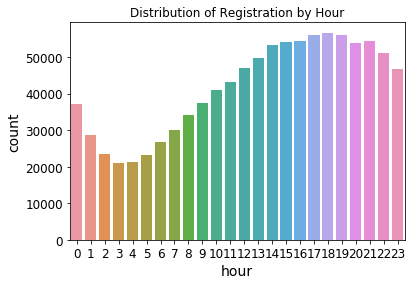

In [18]:
count_plot('hour', 'Distribution of Registration by Hour')

We can see some pattern in the hourly registration: The peak hour would be about 18 pm.

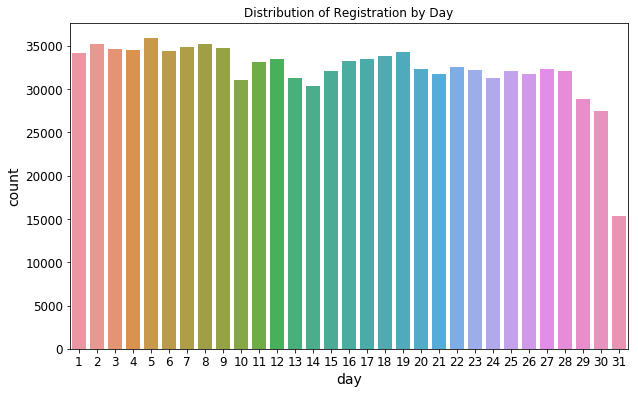

In [19]:
plt.figure(figsize=(10,6))
count_plot('day', 'Distribution of Registration by Day')

The registration at the beginning of the month is relatively strong.

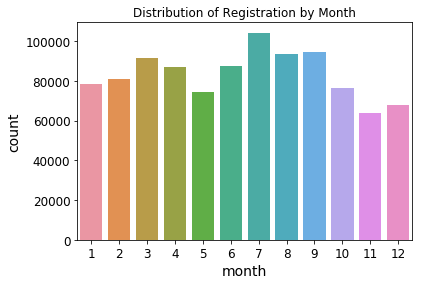

In [20]:
count_plot('month', 'Distribution of Registration by Month')

The registration at the summer season is stronger than the winter season.

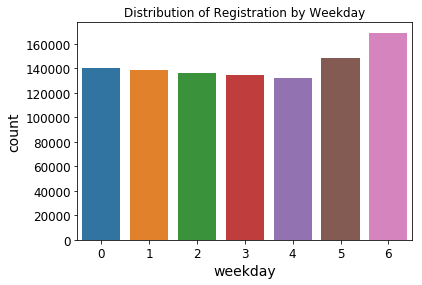

In [21]:
count_plot('weekday', 'Distribution of Registration by Weekday')

The registration on the weekend is stronger than on the weekdays.

Text(0.5,1,'Distribution of Registration by Partner')

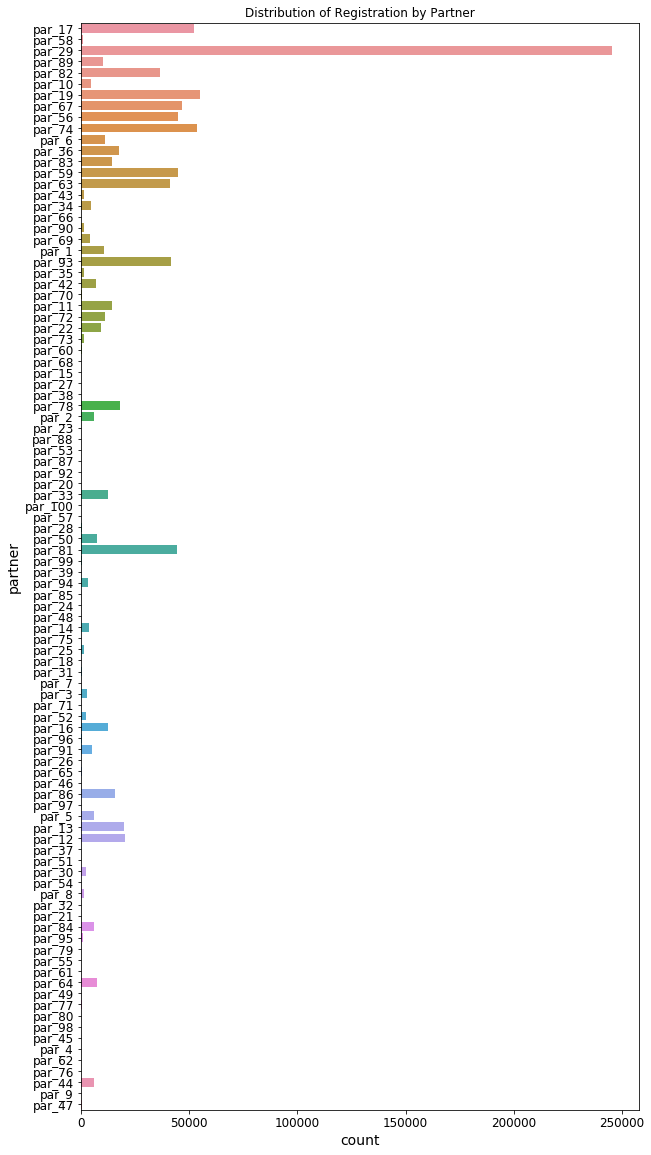

In [22]:
plt.figure(figsize=(10,20))
sns.countplot(y='partner', data=train, orient='h')
plt.title('Distribution of Registration by Partner')

Surprisely, we can see that par_29 has almost 25% share of the registration.

Text(0.5,1,'Distribution of Registration by Domain')

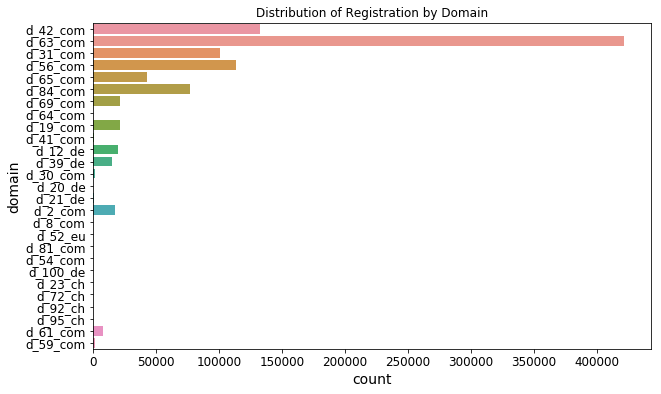

In [23]:
plt.figure(figsize=(10,6))
sns.countplot(y='domain', data=train, orient='h')
plt.title('Distribution of Registration by Domain')

We can see that some domain has been quite dominant in the share of registration: for example d_63_com, which has shared up to 40% of the registration.

## Univariate Analysis - Summary

In this section, we look at the distribution of each attributes. With the univariate plotting, we can have an overview as following:

- **is_fake**: There is about 7.6% of the fake registration.
- **username**: There is some usernames used up to 200 times, like info or admin. The notebook would take a closer look at the bivariate analysis section about the relationship between username and the target.
- **password**: There is some password used up to 5k times. The notebook would take a closer look at the bivariate analysis section about the relationship between password and the target.
- **publisher**: The ratio_fake_registration by the top 10 publishers is compared to the overall relatively low. This could means that the fraud cases could happen more often by median/small publisher.
- **hour**: We can see some pattern in the hourly registration: The peak hour would be about 18 pm.
- **day**: The registration at the beginning of the month is relatively strong.
- **month**: The registration at the summer season is stronger than the winter season.
- **weekday**: The registration on the weekend is stronger than on the weekdays.
- **partner**: We can see that par_29 has almost 25% share of the registration.
- **domain**: We can see that some domain has been quite dominant in the share of registration: for example d_63_com, which has shared up to 40% of the registration.

## Bivariate Analysis - Correlations

Now that we have transformed the categorical attributes with one-hot-encoding, we can take a look at the correlations between features and the target. We will use Pearson correlation coefficient with the `.coor` method in dataframe.

In [24]:
tr[num_var + ['is_fake']].corr()['is_fake'].sort_values(ascending=False)

is_fake                    1.000000
publisher_leave_one_out    0.691206
username_leave_one_out     0.317823
partner_leave_one_out      0.256682
domain_leave_one_out       0.066630
password_leave_one_out     0.061960
cw                         0.027173
month                      0.025017
day                        0.024527
weekday                   -0.006109
hour                      -0.052666
year                            NaN
Name: is_fake, dtype: float64

Now that we have the correlation coefficient between the features and target variables, we can figure out some features which is relevant to the target:

- **publisher_leave_one_out**: According to the Pearson's correlation coefficient, *publisher* shows the strongest relationship with the target.
- **username_leave_one_out**: *Username* shows some relationship with the target.
- **partner_leave_one_out**: According to the Pearson's correlation coefficient, *partner* shows some relationship with the target.

## Bivariate Analysis - Plotting

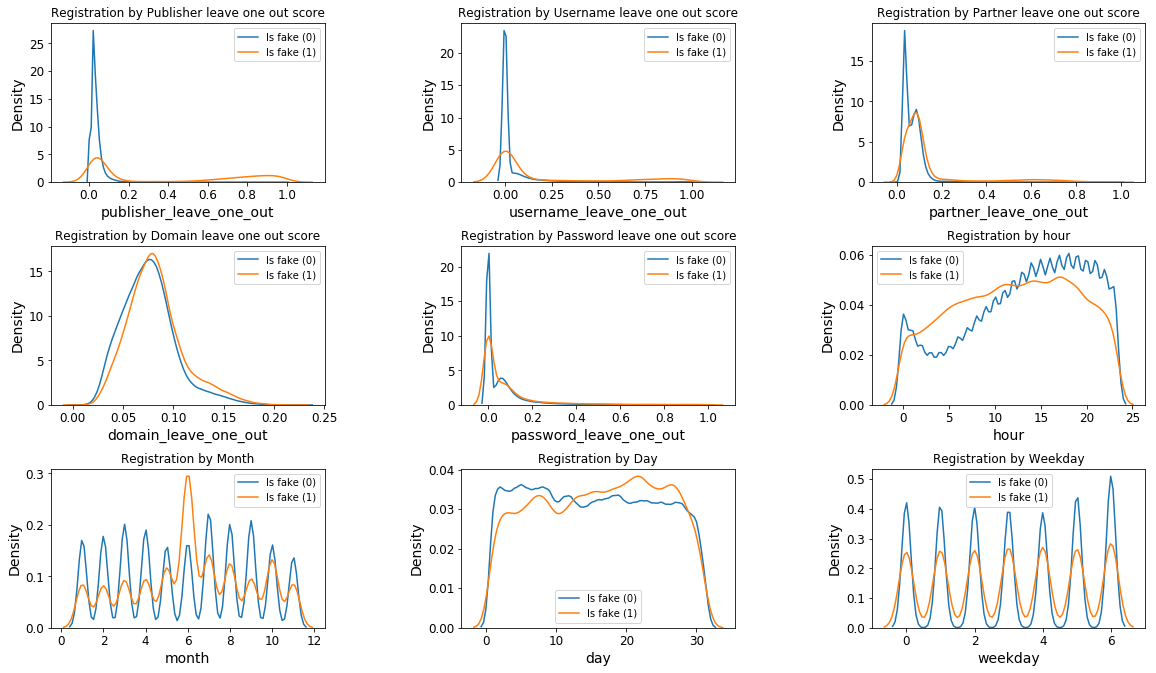

In [25]:
plt.figure(figsize=(8,10))
plt.subplot(331)
plot_density('publisher_leave_one_out', 1, 'Registration by Publisher leave one out score')
plt.subplot(332)
plot_density('username_leave_one_out', 1, 'Registration by Username leave one out score')
plt.subplot(333)
plot_density('partner_leave_one_out', 1, 'Registration by Partner leave one out score')
plt.subplot(334)
plot_density('domain_leave_one_out', 1, 'Registration by Domain leave one out score')
plt.subplot(335)
plot_density('password_leave_one_out', 1, 'Registration by Password leave one out score')
plt.subplot(336)
plot_density('hour', 24, 'Registration by hour')
plt.subplot(337)
plot_density('month', 12, 'Registration by Month')
plt.subplot(338)
plot_density('day', 31, 'Registration by Day')
plt.subplot(339)
plot_density('weekday', 31, 'Registration by Weekday')
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=2, hspace=0.4,
                    wspace=0.5)

**Summary of plotting above**

The density plots show some patterns in the behavior of fake registration:

- From the plotting we can see that the feature **publisher** and **username** are a relatively strong feature to identify fraud.
- The **hourly hehavior** of fraud is also relatively different than none_fraud registration. We can see that a none_fraud registration would be more active during normal hours: from 10 am - 23 pm. Fraud registration would also prefer those hours in the mid-night to early morning.
- The **monthly behavior** also shows that a peak of June as fraud registration, whereas none_fraud registrations are quite equally distributed.
- The **behavior in the month** is also interesting. We can see that the fraud tends to be more active at the end of the month, whereas none_fraud registrations are more active at the beginning of the month.
- The **weekday** feature also shows some interesting patterns. For example: Fraud registration is distributed quite equally within the week, whereas the none_fraud registration would be more active on the weekends.

### Password & Username

We will take a look at the password and username here to see that if some username or password might have been used often for fraud registration.

In [26]:
tmp = train[['username', 'password']][train['is_fake']==1]

In [27]:
tmp.groupby('username', as_index=False).count().rename(columns={'password': 'cnt'}).sort_values('cnt', ascending=False)[:10]

,username,cnt
5218,aaaaaa,22
17951,ddddd,18
32301,info,18
1209,2000,17
13751,cccccc,17
603,1234,16
46328,mmmmm,16
5206,aaaa,15
607,12345,14
9509,bbbb,14


In [28]:
tmp.groupby('password', as_index=False).count().rename(columns={'username': 'cnt'}).sort_values('cnt', ascending=False)[:10]

,password,cnt
4436,123456,450
4452,12345678,140
52919,qwerty,128
50429,password,127
4453,123456789,122
4423,12345,90
3570,111111,72
4446,1234567,50
4408,1234,49
64476,xxxxxxxx,44


We can see that the fraud registrations tend to use simple username as well as simple password:

- It might only contains digits or letter
- It might only contains single letter.

In [29]:
del tmp

## Bivariate Analysis - Summary

**What are some of the relationships observed in this part of investigation?**

This section is oriented with an analysis of correlation coefficient between feature variables and target status. Based on pearson's correlation coefficient analysis, we could notice the following pair of relationships:

- **Publisher and is_fake**: highly correlative with correlation coefficienct 0.69.
- **Username and is_fake**: relatively strong correlative with correlation coefficienct of 0.31. Fraud registrations tend to use simple username:
    - It might only contains digits or letter
    - It might only contains single letter.
- **Partner and is_fake**: This shows certain relationship with correlation coefficient of 0.261865. Some probably assumption could be that publishers who conduct fraud prefer certain types of partners.
- **Time patterns**: The density plot shows some time patterns of fraud behavior: 
    - The hourly hehavior of fraud is also relatively different than none_fraud registration. We can see that a none_fraud registration would be more active during normal hours: from 10 am - 23 pm. Fraud registration would also prefer those hours in the mid-night to early morning.
    - The monthly behavior also shows that a peak of June as fraud registration, whereas none_fraud registrations are quite equally distributed.
    - The behavior in the month is also interesting. We can see that the fraud tends to be more active at the end of the month, whereas none_fraud registrations are more active at the beginning of the month.
    - The weekday feature also shows some interesting patterns. For example: Fraud registration is distributed quite equally within the week, whereas the none_fraud registration would be more active on the weekends.

**What is the strongest relationship found?**

- The strongest relationship found here is between **Publisher and is_fake**. 

# 5. Feature Engineering

Before training the model, let's generate some new features which might also be insightful in detecting the fake registration. From the bivariate analysis, we see some time pattern in fraud behavior and publisher behavior, which gives us the insight to generate the feature on publisher level:

- ratio_fraud_last_month_per_publisher
- ratio_weekend_registration_per_publisher
- average_registration_hour_per_publisher
- average_registration_month_per_publisher
- average_registration_day_of_month_per_publisher

In [30]:
new_var = ['ratio_fraud_last_month_per_publisher',  
                'ratio_weekend_registration', 'average_registration_hour', 
                'average_registration_month', 'average_registration_day']

# Create df monthly_publisher_fraud
monthly_publisher_fraud = train.groupby(['publisher', 'month'], as_index=False)['is_fake'].mean().rename(columns={'is_fake': 'ratio_fraud_last_month_per_publisher'})
monthly_publisher_fraud['next_month_id'] = monthly_publisher_fraud['month'] + 1
monthly_publisher_fraud = monthly_publisher_fraud.drop('month', axis=1)


def is_weekend(weekday):
    if weekday in [5,6]:
        return 1
    else:
        return 0
    
    
def is_weekday(weekday):
    if weekday not in [5,6]:
        return 1
    else:
        return 0


# Only use the training data to calculate the ratio
tr['is_weekend'] = tr['weekday'].apply(is_weekend)
tr['is_weekday'] = tr['weekday'].apply(is_weekday)

# Create df publisher_week
publisher_week = tr.groupby(['publisher'], as_index=False)['is_weekend', 'is_weekday'].sum()
publisher_week['ratio_weekend_registration'] = publisher_week['is_weekend'] / (publisher_week['is_weekend'] + publisher_week['is_weekday'])

# Create df publisher_average
publisher_average = tr.groupby(['publisher'], as_index=False)['hour', 'month', 'day'].mean()\
    .rename(columns={'hour': 'average_registration_hour',
                    'month': 'average_registration_month',
                    'day': 'average_registration_day'})


# Merge features to training set
# Merge publisher name to tr_num
def merge_features(df, df_col_publisher):
    df = pd.concat([df, df_col_publisher[['publisher']]], axis=1)
    df = pd.merge(df, monthly_publisher_fraud, how='left', left_on=['publisher', 'month'], right_on=['publisher', 'next_month_id'])
    df = pd.merge(df, publisher_week, how='left', on=['publisher'])
    df = pd.merge(df, publisher_average, how='left', on=['publisher'])
    return df


tr_num = merge_features(tr_num, tr)
te_num = merge_features(te_num, te)

# Train an imputer
imputer_2 = Imputer(strategy='median')
num_var = num_var + new_var
tr_num = tr_num[num_var]
imputer_2.fit(tr_num)

# Impute numerical variable
tr_num = impute_and_clip(tr_num, num_var, imputer_2, False)
te_num = impute_and_clip(te_num, num_var, imputer_2, False)

# 6. Train model

## 6.1 Random Forest Classifier

To get a baseline, we will try the [RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and [ExtraTreesClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier).


In [31]:
# prepare feature and label

X_tr = tr_num
y_tr = tr['is_fake']
X_te = te_num
y_te = te['is_fake']

In [32]:
rf_clf = RandomForestClassifier(random_state=42, n_estimators=200, min_samples_leaf=8)

rf_clf.fit(X_tr, y_tr)
train_proba = rf_clf.predict_proba(X_tr)
te_proba = rf_clf.predict_proba(X_te)
trn_roc_auc = roc_auc_score(y_tr, train_proba[:, 1])
te_roc_auc = roc_auc_score(y_te, te_proba[:, 1])
print('Train_roc_auc %.6f, te_roc_auc %.6f' % (trn_roc_auc, te_roc_auc))

Train_roc_auc 0.994669, te_roc_auc 0.661106


In [33]:
rf_clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)


## Tune parameters for RandomForestClassifier

As we can see the that roc_auc on the training set is far better than that on the validation set. This might be some over-fitting of the model on the training data. Let's try some regulation parameters:

- min_samples_leaf

Moreover, we can tune the parameter *n_estimators*.

In the following we will apply [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to search the best parameters. The parameters of the estimator are optimized by cross-validated grid-search over a parameter grid.

In [34]:
# Comment out this part as this takes too long

# # Use a full grid over all parameters
# param_grid = {"min_samples_leaf": [5, 8],
#               "n_estimators": [100, 150]}
# 
# # run grid search
# grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=param_grid, cv=3)
# grid_search.fit(X_tr, y_tr)
# y_proba = grid_search.predict_proba(X_tr)
# roc_auc = roc_auc_score(y_tr, y_proba[:, 1])
# print('Roc_auc %.6f' % (roc_auc))
# print(grid_search.best_params_)

From the search above, we will figure out the best param at the moment is: `{'min_samples_leaf': 8, 'n_estimators': 100}`.

Now that we have the best params, let's train the final random forest model.

In [35]:
final_rf_clf = RandomForestClassifier(n_estimators=100, min_samples_leaf=8, random_state=42)

final_rf_clf.fit(X_tr, y_tr)
train_proba = final_rf_clf.predict_proba(X_tr)
test_proba = final_rf_clf.predict_proba(X_te)
trn_roc_auc = roc_auc_score(y_tr, train_proba[:, 1])
te_roc_auc = roc_auc_score(y_te, test_proba[:, 1])
print('Train_roc_auc %.6f, Test_roc_auc %.6f' % (trn_roc_auc, te_roc_auc))

Train_roc_auc 0.994429, Test_roc_auc 0.633517


We can see that the *min_sample_leaf* here has not reduce the overfitting. It might need a broader range of grid search. However, this would not be done in this task due to the long running time for the grid search in this machine. 
Compared the roc_auc 0.60 with 0.65 previously, we see the performance of the first random forest model is slightly better. Let's replace the final_rf_clf with the rf_clf.

In [36]:
final_rf_clf = rf_clf

## Feature Importance

The RandomForestClassifier from Scikit learn provides a simple method to see the [importancy of features](http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html).

In [37]:
# function to show feature importance
def show_feature_importance(model, df):
    results = pd.DataFrame({'feature': df.columns.values, 'importance': model.feature_importances_})
    results = results.sort_values('importance', ascending=False)
    plt.figure(figsize=(16,8))
    sns.barplot(x='importance', y='feature', data=results, orient='h')
    plt.title('Feature Importance')

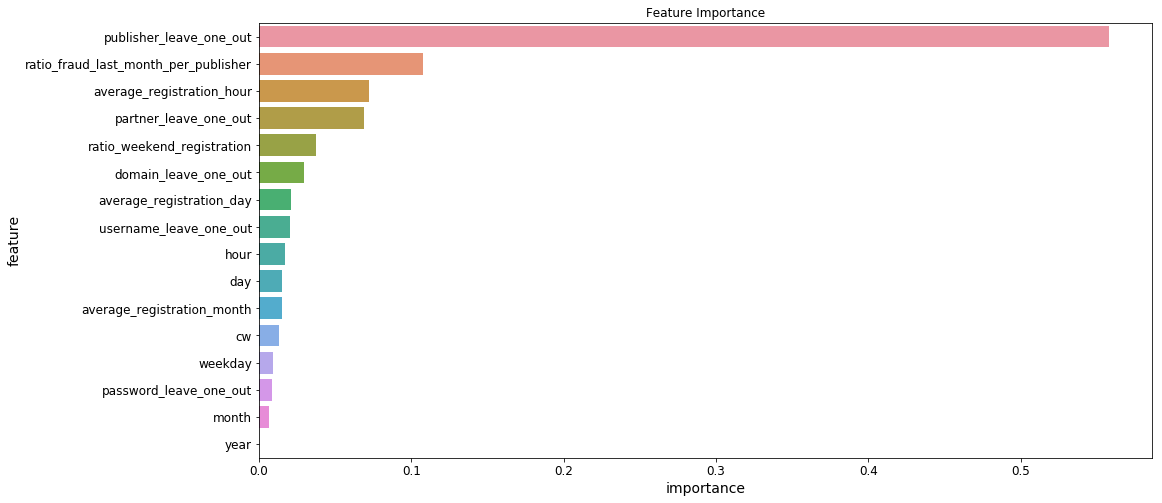

In [38]:
show_feature_importance(final_rf_clf, X_tr)

With the following visualization, we can see that the strongest feature is *publisher_leave_one_out*. The other top 5 features include: *ratio_fraud_last_month_per_publisher*, *average_registration_hour*, *partner_leave_one_out*, *ratio_weekend_registration*.

## 6.2 Extra Trees Classifier

Let's try some other ExtraTreesClassifier, which can be trained faster and reduce over-fitting as well.

In [39]:
extra_tree_clf = ExtraTreesClassifier(random_state=42)

extra_tree_clf.fit(X_tr, y_tr)
train_proba = extra_tree_clf.predict_proba(X_tr)
te_proba = extra_tree_clf.predict_proba(X_te)
trn_roc_auc = roc_auc_score(y_tr, train_proba[:, 1])
te_roc_auc = roc_auc_score(y_te, te_proba[:, 1])
print('Train_roc_auc %.6f, test_roc_auc %.6f' % (trn_roc_auc, te_roc_auc))

Train_roc_auc 1.000000, test_roc_auc 0.536542


## Tune parameters for ExtraTreesClassifier

The roc_auc on the validation set is quite similar with the random_forest_classifier without training. Let's try a GridSearchCV with the extra_tree_classifier. As we see from the grid search for the random forest parameter above that the *min_samples_leaf* doesn't help much in the overfitting in small range of search, let's instead just focus on the *n_estimators* in the following grid_search.

In [40]:
# Comment out this part as this takes too long

# # Use a full grid over all parameters
# param_grid = {"n_estimators": [50, 100, 150]}
# 
# # run grid search
# grid_search = GridSearchCV(ExtraTreesClassifier(random_state=42), param_grid=param_grid, cv=3)
# grid_search.fit(X_tr, y_tr)
# y_proba = grid_search.predict_proba(X_tr)
# roc_auc = roc_auc_score(y_tr, y_proba[:, 1])
# print('Roc_auc %.6f' % (roc_auc))
# print(grid_search.best_params_)

Best params from grid search: 
Roc_auc 1.000000
{'n_estimators': 50}

In [41]:
extra_tree_clf = ExtraTreesClassifier(n_estimators=50, random_state=42)

extra_tree_clf.fit(X_tr, y_tr)
train_proba = extra_tree_clf.predict_proba(X_tr)
test_proba = extra_tree_clf.predict_proba(X_te)
trn_roc_auc = roc_auc_score(y_tr, train_proba[:, 1])
te_roc_auc = roc_auc_score(y_te, test_proba[:, 1])
print('Train_roc_auc %.6f, Test_roc_auc %.6f' % (trn_roc_auc, te_roc_auc))

Train_roc_auc 1.000000, Test_roc_auc 0.664926


Compared the performance between RandomForestClassifier and ExtraTreeClassifier, RandomForestClassifier perform slightly better in roc_auc. So let's stay with the final_rf_clf as our baseline model so far.

## 6.3 Light Gradient Boosting Machine ([LightGBM](http://lightgbm.readthedocs.io/en/latest/))

In order to use this algorithms you can follow the instruction guide [here](http://lightgbm.readthedocs.io/en/latest/Installation-Guide.html) to install the LightGBM.

We can set the metric parameter as `auc`.

In [42]:
gbm_params = {'objective': 'binary',
          'boosting_type': 'gbdt',
          'metric': 'auc',
          'nthreads': 4,
          'shrinkage_rate': 0.025,
          'max_depth': 9,
          'min_samples_leaf': 12,
          'bagging_fraction': 0.7,
          'feature_fraction': 0.7,
          'lambda_l1': 1,
          'lambda_l2': 1}

In [43]:
feature_importance_df = pd.DataFrame()

dtrain = gbm.Dataset(X_tr, y_tr)
dval = gbm.Dataset(X_te, y_te)
lightGBM_clf = gbm.train(params=gbm_params, train_set=dtrain, num_boost_round=3000, verbose_eval=1000, valid_sets=[dtrain, dval], valid_names=['train', 'val'])
feature_importance_df['feature'] = X_tr.columns.values
feature_importance_df['importance'] = lightGBM_clf.feature_importance()
te_proba = lightGBM_clf.predict(X_te)
te_roc_auc = roc_auc_score(y_te, te_proba)
print('Validation_roc_auc %.6f' % (te_roc_auc))

[1000]	train's auc: 0.874728	val's auc: 0.737217
[2000]	train's auc: 0.891659	val's auc: 0.74248
[3000]	train's auc: 0.903921	val's auc: 0.749813
Validation_roc_auc 0.749813


## Models Evaluation

LightGBM perform much better than RandomForestClassifier / ExtraTreesClassifier, as we see that the roc_auc on the validation set reach 0.74. As the gap between train_auc and testing auc, there is still room to improve with performance tuning. 

Let's save the lightGBM_clf as the final model.

## Feature Importance

Let's take a look at the feature importances with the ligthGBM to see if we have similar results with the RandomForestClassifier.

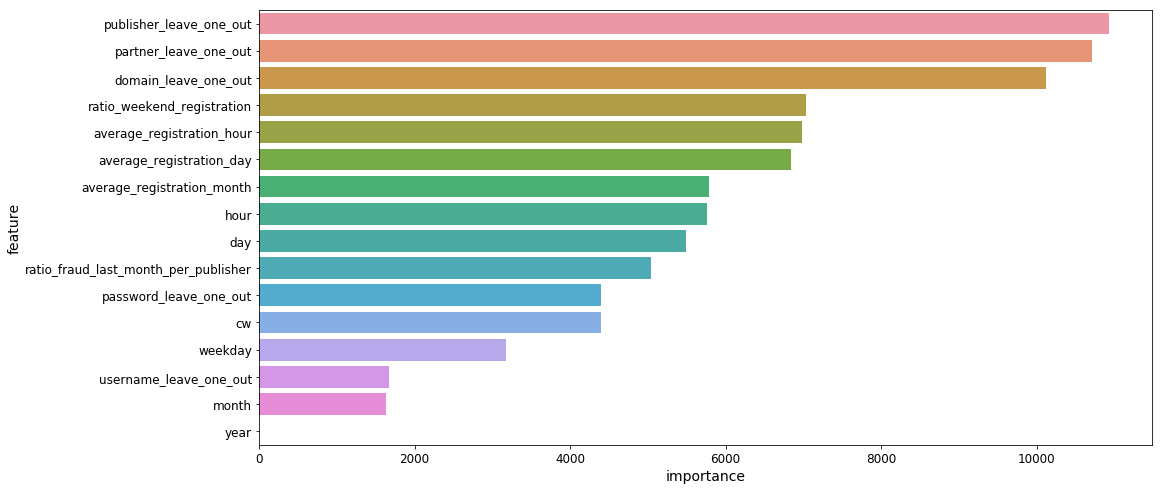

In [44]:
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
plt.figure(figsize=(16, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df, orient='h')

We can see that the strongest feature is still *publisher_leave_one_out*. *partner_leave_one_out* has been the second strongest feature.

Other top 5 features include: *domain_leave_one_out*, *average_registration_hour*, *average_registration_day* / *ratio_weekend_registration*.

We can see quite much similarity among the top features between the lightGBM and RandomForestClassifier. As the LightGBM has reduced the overfitting on the training set and perform better on the testing set, we can regard that the feature_importance results from lightGBM more convincing.